In [221]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt

In [222]:
habitats_data = pd.read_json("/data/nicola/WSH/processed_data/habitats_data.json", orient="records")
hybrid_classes = [1, 2, 3, 31, 32, 34, 4, 40, 41, 42, 43, 44, 45, 5, 6, 60, 61, 62, 63, 64, 65, 66, 7, 8, 9]
habitats_data["Hybrid"] = 0
for i in range(len(hybrid_classes)):
    if hybrid_classes[i]<10:
    	habitats_data.loc[habitats_data["Class"]==hybrid_classes[i],"Hybrid"] = hybrid_classes[i]
    else:
        habitats_data.loc[habitats_data["Group_"]==hybrid_classes[i],"Hybrid"] = hybrid_classes[i]
habitats_data.head(5)
#habitats_data.to_json("/data/nicola/WSH/processed_data/habitats_data.json", orient="records")

,TypoCH_NUM,TypoCH_DE,TypoCH_FR,TypoCH_IT,TypoCH_Sci,Class,Group_,Type,Source,Hybrid
0,1,1 Gewässer,1 Eaux libres,1 Ambienti acquatici,None,1,1,1,1,1
1,11,1.1 Stehende Gewässer,1.1 Eaux calmes,1.1 Acque ferme,None,1,11,11,1,1
2,12,1.2 Fliessgewässer,1.2 Eaux courantes,1.2 Acque correnti,None,1,12,12,1,1
3,2,2 Ufer und der Feuchtgebiete,2 Rivages et lieux humides,2 Rive e luoghi umidi,None,2,2,2,1,2
4,21,2.1 Ufer mit Vegetation,2.1 Rivages avec végétation,2.1 Rive con copertura vegetale,None,2,21,21,1,2


### Cooccurences of classes for species

In [265]:
import torch
import torch.nn.functional as F
import pandas as pd
level = "group"
## Load data
species_habitats_records = pd.read_json("/data/nicola/WSH/processed_data/species_habitats_records.json", orient="records")
habitats_data = pd.read_json("/data/nicola/WSH/processed_data/habitats_data.json", orient="records").set_index("TypoCH_NUM")
## Merge sources
species_habitats_records = species_habitats_records.join(habitats_data[["Class","Group_","Type","Hybrid"]], on="TypoCH_NUM", how="left")
species_habitats_records = species_habitats_records.rename(columns={"Class": "class", "Group_":"group", "Type": "type", "Hybrid":"hybrid"})
## Get unique values of classes
unique_classes = species_habitats_records[level].unique()
## Sort "alphabetically"
unique_classes = list(map(str, unique_classes))
unique_classes.sort()
unique_classes = list(map(int, unique_classes))

In [266]:
len(habitats_data)

156

In [267]:
def get_onehots(entry, unique_classes):
    """Retrieve one_hot encodings"""
    x = [unique_classes.index(c) for c in entry]
    return F.one_hot(torch.tensor(x), num_classes=len(unique_classes)).sum(dim=0).tolist()

def get_species_classes(records, unique_classes, filter_uncommon=True):
    """Get one_hot encoded classes for each species"""
    if filter_uncommon:
        species_classes_counts = pd.DataFrame(records[["species_key",level]].value_counts()).reset_index().rename(columns={0:"count"})
        species_classes_counts = species_classes_counts.join(pd.DataFrame(species_habitats_records["species_key"].value_counts()).rename(columns={"species_key":"total"})["total"], on="species_key", how="inner")
        species_classes_counts["fraction"] = species_classes_counts["count"]/species_classes_counts["total"]
        #for sk in species_classes_counts["species_key"].unique():
        #    species_classes_counts.loc[species_classes_counts["species_key"]==sk,"cutoff"] = species_classes_counts.loc[species_classes_counts["species_key"] == sk,"fraction"].quantile(0.003)
        #records = species_classes_counts[species_classes_counts["fraction"]>species_classes_counts["cutoff"]]
        #records = species_classes_counts[species_classes_counts["fraction"]>species_classes_counts["cutoff"]]
        records = species_classes_counts[species_classes_counts["fraction"]>0.01]
    species_classes = records.groupby("species_key")[level].unique().reset_index().rename(columns={level:"classes"})
    species_classes["classes_onehot"] = species_classes["classes"].apply(lambda x : get_onehots(x, unique_classes))
    return species_classes

In [268]:
species_habitats_records.head()

,zone_id,grid_id,TypoCH_NUM,species_key,shape_area,canton,split,class,group,type,hybrid
0,96603,1537,454,2891147,102800.130038,VD,train,4,45,454,45
1,95033,1625,625,3170040,15280.189843,VD,train,6,62,625,62
2,94466,1713,452,2891147,69785.151723,VD,train,4,45,452,45
3,94462,1713,453,5371685,104539.091134,VD,train,4,45,453,45
4,94901,1804,625,1703827,36810.089390,VD,train,6,62,625,62


Text(0, 0.5, 'Number of occurences')

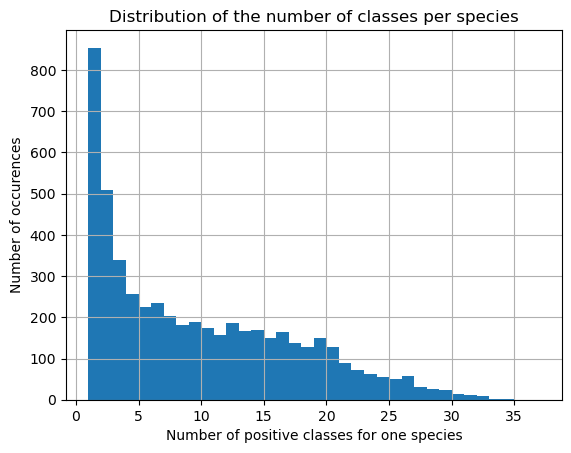

In [269]:
temp = get_species_classes(species_habitats_records, unique_classes, filter_uncommon=False).set_index("species_key")
temp["num_habitats"] = temp["classes"].apply(lambda x : len(x))
plt.figure()
temp.num_habitats.hist(bins=torch.arange(1,len(species_habitats_records[level].unique())+1).tolist())
plt.title("Distribution of the number of classes per species")
plt.xlabel("Number of positive classes for one species")
plt.ylabel("Number of occurences")

In [270]:
temp

,classes,classes_onehot,num_habitats
species_key,,,
1013335,"[4, 33, 62, 66, 45, 41]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, ...",6
1013651,[45],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1035167,"[4, 71, 62, 66, 63, 34, 60, 92, 42, 81, 82, 64...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, ...",14
1035185,"[42, 61, 82, 62, 45, 4, 63, 60, 66, 34, 92, 81...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, ...",15
1035194,"[53, 71, 33, 45, 66, 92, 4, 34, 60, 43, 42, 44]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, ...",12
...,...,...,...
11049437,[82],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
11071158,"[62, 42]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
11106107,"[82, 43, 53]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3


In [271]:
len(species_habitats_records[level].unique())

37

Text(0, 0.5, 'Number of occurences')

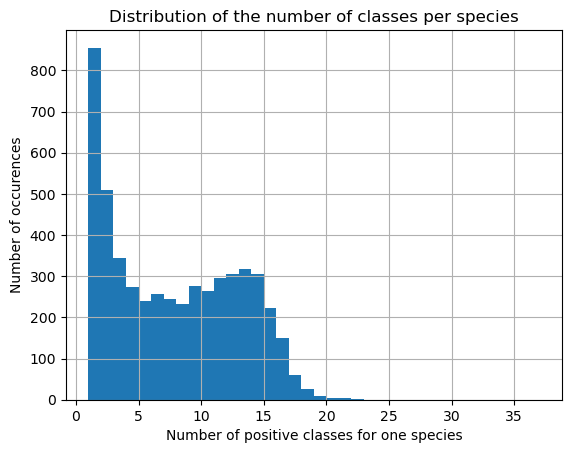

In [272]:
temp = get_species_classes(species_habitats_records, unique_classes, filter_uncommon=True).set_index("species_key")
temp["num_habitats"] = temp["classes"].apply(lambda x : len(x))
plt.figure()
temp.num_habitats.hist(bins=torch.arange(1,len(species_habitats_records[level].unique())+1).tolist())
plt.title("Distribution of the number of classes per species")
plt.xlabel("Number of positive classes for one species")
plt.ylabel("Number of occurences")

In [273]:
idx = get_species_classes(species_habitats_records, unique_classes, filter_uncommon=True).set_index("species_key").index
out = pd.DataFrame(get_species_classes(species_habitats_records, unique_classes, filter_uncommon=True).set_index("species_key")["classes_onehot"].tolist(), columns=unique_classes).astype(int)
out.index = idx
out.head()

,11,12,2,21,22,23,24,3,31,32,...,64,65,66,71,81,82,9,92,93,94
species_key,,,,,,,,,,,,,,,,,,,,,
1013335,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1013651,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1035167,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,0,1,0,0
1035185,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,1,0,0,0,0
1035194,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [274]:
import numpy as np
cooccurence = out.T.dot(out)
cooccurence = cooccurence/len(idx)
#np.fill_diagonal(cooccurence.values, 0)

<Axes: title={'center': 'Cooccurences of classes accross species\n(as a fraction of total number of species)'}>

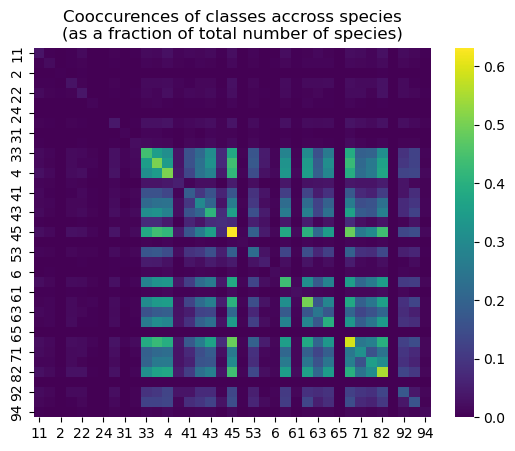

In [276]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
#plt.title("Cooccurences of classes accross species (fraction of total number of species) \n without auto cooccurence (diagonal is set to 0)")
plt.title("Cooccurences of classes accross species\n(as a fraction of total number of species)")
sns.heatmap(cooccurence, cmap="viridis")
#plt.tight_layout()

In [277]:
out.T.values.sum()

38366

### Common species stats

In [278]:
arr = []
cols = out.columns
for i in range(len(cols)):
    vals = []
    for j in range(len(cols)):
        if j==i:
            vals.append(1)
        else:
            vals.append((out[cols[i]].values*out[cols[j]].values).sum()/out[cols[i]].values.sum())
    arr.append(vals)
arr = np.array(arr)

Text(46.972222222222214, 0.5, 'class i')

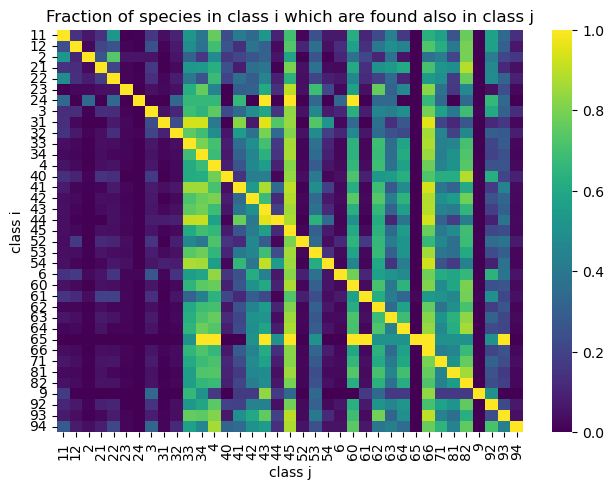

In [280]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
plt.title("Fraction of species in class i which are found also in class j")
sns.heatmap(arr, cmap="viridis", xticklabels=cols, yticklabels=cols)
plt.tight_layout()
plt.xlabel("class j")
plt.ylabel("class i")


In [237]:
train = pd.read_json("/data/nicola/WSH/final_data/train_data.json", orient="records")

In [238]:
## Number of classes in splits
print(len(pd.read_json("/data/nicola/WSH/final_data/train_data.json", orient="records").maps_based_class.unique()))
print(len(pd.read_json("/data/nicola/WSH/final_data/val_data.json", orient="records").maps_based_class.unique()))
print(len(pd.read_json("/data/nicola/WSH/final_data/test_data.json", orient="records").maps_based_class.unique()))

37
35
37


In [239]:
print(len(pd.read_json("/data/nicola/WSH/final_data/train_data.json", orient="records")))
print(len(pd.read_json("/data/nicola/WSH/final_data/val_data.json", orient="records")))
print(len(pd.read_json("/data/nicola/WSH/final_data/test_data.json", orient="records")))

15504
2525
7934


In [240]:
import pandas as pd
pd.read_json("/data/nicola/WSH/final_data/test_data.json", orient="records")[["zone_id","maps_based_class","species_key","species_based_class"]]

,zone_id,maps_based_class,species_key,species_based_class
0,172,66,"[5371685, 5402943]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ..."
1,210,54,[5385604],"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, ..."
2,213,43,"[3032585, 7270427]","[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, ..."
3,214,23,"[8207244, 4299597]","[1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, ..."
4,216,22,[3032585],"[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."
...,...,...,...,...
7929,98095,43,"[3170040, 2812375, 3029627, 1537719, 3189747, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, ..."
7930,98096,53,[3928139],"[1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, ..."
7931,98097,53,[2882835],"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, ..."
7932,98101,66,"[5275365, 3112620]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, ..."


In [241]:
species_habitats_records.groupby("species_key")["hybrid"].unique().reset_index().rename(columns={level:"classes"})

,species_key,classes
0,1013335,"[4, 3, 62, 66, 45, 41]"
1,1013651,[45]
2,1035167,"[4, 7, 62, 66, 63, 34, 60, 9, 42, 8, 64, 45, 3]"
3,1035185,"[42, 61, 8, 62, 45, 4, 63, 60, 66, 34, 9, 64, ..."
4,1035194,"[5, 7, 3, 45, 66, 9, 4, 34, 60, 43, 42, 44]"
...,...,...
5193,11049437,[8]
5194,11071158,"[62, 42]"
5195,11106107,"[8, 43, 5]"
5196,11986045,[9]


In [242]:
a = pd.DataFrame(species_habitats_records[["species_key","hybrid"]].value_counts()).reset_index().rename(columns={0:"count"})
a = a.join(pd.DataFrame(species_habitats_records["species_key"].value_counts()).rename(columns={"species_key":"total"})["total"], on="species_key", how="inner")
a["fraction"] = a["count"]/a["total"]

In [243]:
for sk in a["species_key"].unique():
    a.loc[a["species_key"]==sk,"cutoff"] = a.loc[a["species_key"] == sk,"fraction"].quantile(0.003)

In [244]:
a[a["species_key"] == 3188924]

,species_key,hybrid,count,total,fraction,cutoff
16678,3188924,8,9,24,0.375000,0.041667
17330,3188924,4,8,24,0.333333,0.041667
30543,3188924,9,2,24,0.083333,0.041667
30544,3188924,60,2,24,0.083333,0.041667
38933,3188924,66,1,24,0.041667,0.041667
38942,3188924,64,1,24,0.041667,0.041667
38944,3188924,62,1,24,0.041667,0.041667


In [245]:
a[a["species_key"] == 1035167]

,species_key,hybrid,count,total,fraction,cutoff
19392,1035167,3,6,40,0.150,0.025
19458,1035167,34,6,40,0.150,0.025
24574,1035167,60,4,40,0.100,0.025
24591,1035167,64,4,40,0.100,0.025
24620,1035167,4,4,40,0.100,0.025
25012,1035167,8,3,40,0.075,0.025
25030,1035167,66,3,40,0.075,0.025
25046,1035167,42,3,40,0.075,0.025
33034,1035167,9,2,40,0.050,0.025
33047,1035167,45,2,40,0.050,0.025


In [246]:
a.describe()

,species_key,hybrid,count,total,fraction,cutoff
count,4.347100e+04,43471.000000,43471.000000,43471.000000,43471.000000,43471.000000
mean,4.100599e+06,33.813117,25.271652,439.362932,0.119574,0.051466
std,2.224225e+06,24.219867,66.346870,664.975081,0.181798,0.154153
min,1.013335e+06,1.000000,1.000000,1.000000,0.000113,0.000115
25%,2.529113e+06,7.000000,2.000000,40.000000,0.017699,0.002133
50%,3.093337e+06,41.000000,5.000000,178.000000,0.054015,0.006329
75%,5.361982e+06,60.000000,20.000000,556.000000,0.138889,0.026711
max,1.215520e+07,66.000000,4399.000000,8886.000000,1.000000,1.000000


In [247]:
a[a["fraction"]<a["cutoff"]].describe()

,species_key,hybrid,count,total,fraction,cutoff
count,1.311000e+03,1311.00000,1311.000000,1311.000000,1311.000000,1311.000000
mean,4.183029e+06,32.37376,1.612510,371.543097,0.084564,0.085163
std,2.267677e+06,23.87718,5.857673,701.589827,0.118445,0.118780
min,1.035185e+06,1.00000,1.000000,3.000000,0.000113,0.000115
25%,2.551662e+06,7.00000,1.000000,9.500000,0.003106,0.003280
50%,3.112801e+06,40.00000,1.000000,79.000000,0.016260,0.016431
75%,5.371704e+06,60.00000,1.000000,439.500000,0.142857,0.143714
max,1.100725e+07,66.00000,207.000000,8886.000000,0.454545,0.454818


In [248]:
a[a["fraction"]>a["cutoff"]].describe()

,species_key,hybrid,count,total,fraction,cutoff
count,3.231100e+04,32311.000000,32311.000000,32311.00000,32311.000000,32311.000000
mean,4.125115e+06,34.125097,33.560212,524.97230,0.108794,0.017138
std,2.217438e+06,24.211147,75.136228,710.12288,0.134727,0.038968
min,1.013335e+06,1.000000,2.000000,3.00000,0.000225,0.000115
25%,2.544165e+06,7.000000,4.000000,78.00000,0.023077,0.001760
50%,3.109086e+06,41.000000,10.000000,256.00000,0.061856,0.004630
75%,5.367098e+06,60.000000,31.000000,671.00000,0.139429,0.013889
max,1.110611e+07,66.000000,4399.000000,8886.00000,0.988281,0.454818


In [249]:
train = pd.read_json("/data/nicola/WSH/final_data/train_data.json", orient="records")
train_species = train["species_key"]
train_species = train_species.to_list()
train_species = sum(train_species, [])
train_species = list(set(train_species))
len(train_species)

3137

In [250]:
val = pd.read_json("/data/nicola/WSH/final_data/val_data.json", orient="records")
val_species = val["species_key"]
val_species = val_species.to_list()
val_species = sum(val_species, [])
val_species = list(set(val_species))
len(val_species)

1625

In [251]:
test = pd.read_json("/data/nicola/WSH/final_data/test_data.json", orient="records")
test_species = test["species_key"]
test_species = test_species.to_list()
test_species = sum(test_species, [])
test_species = list(set(test_species))
len(test_species)

2470

In [252]:
test_unique_species = [spe for spe in test_species if spe not in train_species]
#test_unique_species = [spe for spe in test_unique_species if spe not in val_species]
len(test_unique_species)

393

In [253]:
out.loc[test_unique_species]

,1,2,3,31,32,34,4,40,41,42,...,60,61,62,63,64,65,66,7,8,9
species_key,,,,,,,,,,,,,,,,,,,,,
5341198,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
1785887,1,0,1,0,0,0,0,1,0,1,...,0,0,0,1,1,0,1,0,1,1
2007097,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1884255,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5415012,0,1,0,0,0,0,1,0,0,0,...,1,0,1,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1982406,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1343441,0,0,1,0,0,1,1,0,0,0,...,0,0,1,0,1,0,1,0,1,0
5144534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [254]:
def check(species_list, reference_list):
    out = 1
    for i in species_list:
        if i not in reference_list:
            out = 0
    return out


In [255]:
a = pd.read_json("/data/nicola/WSH/final_data/species_keys.json", orient="records").set_index("ID")
a = temp.loc[a["species_key"].to_list()]
half1 = a.sample(frac=0.5)
half2 = a.drop(half1.index)

<Axes: >

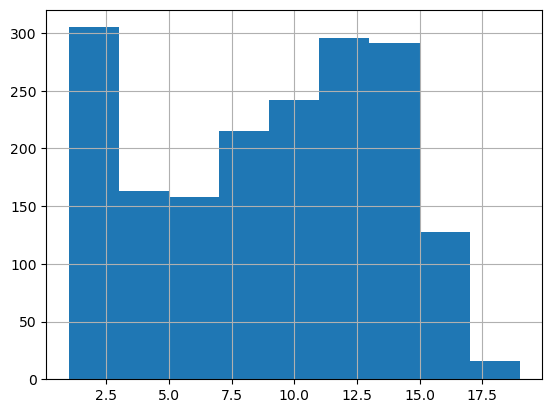

In [256]:
half1.num_habitats.hist(bins=9)

<Axes: >

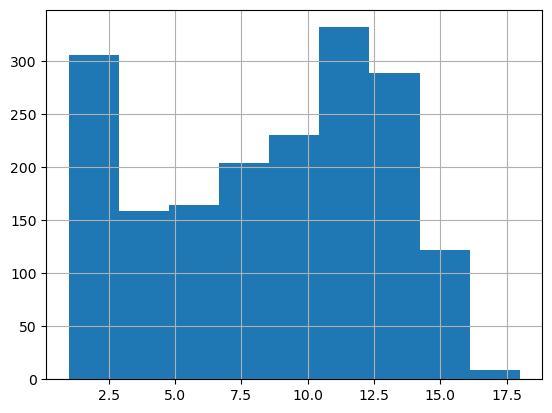

In [257]:
half2.num_habitats.hist(bins=9)

In [258]:
all_data = pd.read_json("/data/nicola/WSH/final_data/all_data.json", orient="records")
all_data["only_in_half1"] = all_data["species_key"].apply(lambda x : check(x,half1.index.to_list()))
all_data["only_in_half2"] = all_data["species_key"].apply(lambda x : check(x, half2.index.to_list()))

In [259]:
all_data

,zone_id,maps_based_class,split,shape_area,species_key,species_count,species_based_class,num_classes,only_in_half1,only_in_half2
0,9,45,train,665918.930058,"[3032837, 3170807, 3105433, 2883073]",4,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, ...",25,0,0
1,10,43,train,2991.243434,[4299368],1,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",27,0,1
2,13,66,train,230749.174683,[2891147],1,"[1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...",32,0,1
3,26,43,train,400775.100939,"[5137582, 7799370]",2,"[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, ...",19,0,0
4,29,54,train,101384.855230,"[8207244, 5352367, 3170807]",3,"[1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, ...",23,0,0
...,...,...,...,...,...,...,...,...,...,...
25958,98095,43,test,63666.903126,"[3170040, 2812375, 3029627, 1537719, 3189747, ...",7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, ...",7,0,0
25959,98096,53,test,414.649751,[3928139],1,"[1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, ...",28,0,1
25960,98097,53,test,3613.157923,[2882835],1,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, ...",27,0,1
25961,98101,66,test,52057.227924,"[5275365, 3112620]",2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, ...",13,1,0


In [260]:
split_1 = all_data.loc[all_data["only_in_half1"]==1]
split_2 = all_data.loc[all_data["only_in_half2"]==1]

In [261]:
split_1.describe()

,zone_id,maps_based_class,shape_area,species_count,num_classes,only_in_half1,only_in_half2
count,7173.000000,7173.000000,7.173000e+03,7173.000000,7173.000000,7173.0,7173.0
mean,49047.060783,50.160742,7.948051e+04,1.418793,23.753799,1.0,0.0
std,28635.881634,24.433919,2.375838e+05,0.860287,6.857375,0.0,0.0
min,37.000000,2.000000,8.114492e+00,1.000000,1.000000,1.0,0.0
25%,23850.000000,41.000000,6.670467e+03,1.000000,20.000000,1.0,0.0
50%,47504.000000,45.000000,2.183784e+04,1.000000,25.000000,1.0,0.0
75%,73747.000000,66.000000,7.125939e+04,2.000000,29.000000,1.0,0.0
max,98101.000000,94.000000,9.066736e+06,10.000000,34.000000,1.0,0.0


In [262]:
split_1.species_count.value_counts()

1     5206
2     1327
3      416
4      132
5       56
6       18
10       7
8        6
7        5
Name: species_count, dtype: int64

In [263]:
split_2.describe()

,zone_id,maps_based_class,shape_area,species_count,num_classes,only_in_half1,only_in_half2
count,5610.000000,5610.000000,5.610000e+03,5610.000000,5610.000000,5610.0,5610.0
mean,47787.179857,50.893939,1.014752e+05,1.321747,22.730303,0.0,1.0
std,28729.499686,23.063803,5.086679e+05,0.726231,6.445777,0.0,0.0
min,10.000000,2.000000,1.376115e+01,1.000000,1.000000,0.0,1.0
25%,22779.500000,41.000000,7.494339e+03,1.000000,19.000000,0.0,1.0
50%,48073.000000,45.000000,2.742118e+04,1.000000,24.000000,0.0,1.0
75%,71893.500000,66.000000,8.679084e+04,1.000000,27.000000,0.0,1.0
max,98118.000000,94.000000,3.100713e+07,8.000000,32.000000,0.0,1.0


In [264]:
split_2.species_count.value_counts()

1    4368
2     879
3     233
4      85
5      28
6      10
7       6
8       1
Name: species_count, dtype: int64